In [1]:
import sys
!{sys.executable} -m pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from io import StringIO

# --- 1. RAW DATA (Seasons 2024, 2025, 2026) ---
# Raw data extracted from StatMuse (simulated for this project)

data_2024 = """Fri 4/12 SAS vs DEN DEN W 121-120 37 34 12 5 1 2
Tue 4/9 SAS @ MEM MEM W 102-87 31 18 7 6 0 7
Sun 4/7 SAS vs PHI PHI L 126-133 43 33 18 6 0 7
Fri 4/5 SAS @ NOP NOP W 111-109 34 17 12 9 1 3
Tue 4/2 SAS @ DEN DEN L 105-110 34 23 15 8 1 9
Sun 3/31 SAS vs GSW GSW L 113-117 31 32 9 5 4 3
Fri 3/29 SAS vs NYK NYK W 130-126 38 40 20 7 2 1
Wed 3/27 SAS @ UTA UTA W 118-111 30 19 8 6 0 5
Sat 3/23 SAS vs PHX PHX L 106-131 21 13 5 4 0 1
Fri 3/22 SAS vs MEM MEM L 97-99 33 31 16 5 2 3
Tue 3/19 SAS vs DAL DAL L 107-113 32 12 11 3 1 6
Sun 3/17 SAS vs BKN BKN W 122-115 36 33 15 7 0 7
Fri 3/15 SAS vs DEN DEN L 106-117 33 17 9 2 2 3
Tue 3/12 SAS vs HOU HOU L 101-103 31 13 10 6 1 2
Mon 3/11 SAS vs GSW GSW L 102-112 31 27 14 3 1 2
Tue 3/5 SAS @ HOU HOU L 101-114 31 10 11 3 0 7
Sun 3/3 SAS vs IND IND W 117-105 31 31 12 6 1 6
Thu 2/29 SAS vs OKC OKC W 132-118 32 28 13 7 2 5
Tue 2/27 SAS @ MIN MIN L 105-114 34 17 13 5 2 4
Sun 2/25 SAS @ UTA UTA L 109-128 27 22 10 2 1 5
Fri 2/23 SAS @ LAL LAL L 118-123 31 27 10 8 5 5
Thu 2/22 SAS @ SAC SAC L 122-127 31 19 13 4 5 5
Wed 2/14 SAS @ DAL DAL L 93-116 27 26 9 5 1 3
Mon 2/12 SAS @ TOR TOR W 122-99 29 27 14 5 2 10
Sat 2/10 SAS @ BKN BKN L 103-123 29 21 4 3 0 1
Thu 2/8 SAS @ ORL ORL L 111-127 23 15 1 2 1 3
Wed 2/7 SAS @ MIA MIA L 104-116 28 18 13 3 1 1
Sat 2/3 SAS vs CLE CLE L 101-117 27 19 14 3 2 2
Fri 2/2 SAS vs NOP NOP L 113-114 28 16 14 7 2 3
Wed 1/31 SAS vs ORL ORL L 98-108 30 21 8 3 2 5
Mon 1/29 SAS vs WAS WAS L 113-118 31 22 11 4 1 3
Sat 1/27 SAS vs MIN MIN W 113-112 30 23 10 6 2 2
Fri 1/26 SAS vs POR POR W 116-100 29 23 12 4 2 2
Wed 1/24 SAS vs OKC OKC L 114-140 28 24 12 4 1 4
Mon 1/22 SAS @ PHI PHI L 123-133 28 33 7 2 0 2
Sat 1/20 SAS @ WAS WAS W 131-127 28 24 8 4 0 6
Wed 1/17 SAS @ BOS BOS L 98-117 27 27 5 1 0 1
Mon 1/15 SAS @ ATL ATL L 99-109 27 26 13 2 2 5
Fri 1/12 SAS vs CHA CHA W 135-99 20 26 11 1 0 2
Wed 1/10 SAS @ DET DET W 130-108 21 16 12 10 0 0
Sun 1/7 SAS @ CLE CLE L 115-117 25 24 10 3 1 5
Thu 1/4 SAS vs MIL MIL L 121-125 26 27 9 1 1 5
Tue 1/2 SAS @ MEM MEM L 98-106 26 20 7 1 0 4
Sun 12/31 SAS vs BOS BOS L 101-134 24 21 7 3 0 1
Thu 12/28 SAS @ POR POR W 118-105 24 30 6 6 0 7
Tue 12/26 SAS vs UTA UTA L 118-130 24 15 7 4 1 5
Thu 12/21 SAS @ CHI CHI L 95-114 22 7 5 5 2 3
Sun 12/17 SAS vs NOP NOP L 110-146 31 17 13 4 1 4
Fri 12/15 SAS vs LAL LAL W 129-115 31 13 15 5 2 2
Wed 12/13 SAS vs LAL LAL L 119-122 33 30 13 2 3 6
Mon 12/11 SAS @ HOU HOU L 82-93 33 15 18 3 0 5
Fri 12/8 SAS vs CHI CHI L 112-121 32 21 20 4 1 4
Wed 12/6 SAS @ MIN MIN L 94-102 32 12 10 1 1 1
Thu 11/30 SAS vs ATL ATL L 135-137 29 21 12 2 2 4
Sun 11/26 SAS @ DEN DEN L 120-132 25 22 11 2 6 4
Fri 11/24 SAS @ GSW GSW L 112-118 35 22 9 4 1 2
Wed 11/22 SAS vs LAC LAC L 102-109 33 22 15 3 1 3
Mon 11/20 SAS vs LAC LAC L 99-124 27 9 3 4 0 2
Sat 11/18 SAS vs MEM MEM L 108-120 31 19 13 4 1 8
Fri 11/17 SAS vs SAC SAC L 120-129 30 27 9 0 2 0
Tue 11/14 SAS @ OKC OKC L 87-123 28 8 14 2 0 2
Sun 11/12 SAS vs MIA MIA L 113-118 34 18 11 7 1 1
Fri 11/10 SAS vs MIN MIN L 110-117 35 29 9 4 1 4
Wed 11/8 SAS @ NYK NYK L 105-126 30 14 9 2 0 1
Mon 11/6 SAS @ IND IND L 111-152 21 13 10 0 1 2
Sun 11/5 SAS vs TOR TOR L 116-123 38 20 9 4 1 5
Thu 11/2 SAS @ PHX PHX W 132-121 34 38 10 2 1 2
Tue 10/31 SAS @ PHX PHX W 115-114 28 18 8 1 0 4
Sun 10/29 SAS @ LAC LAC L 83-123 26 11 5 2 1 1
Fri 10/27 SAS vs HOU HOU W 126-122 31 21 12 1 3 3
Wed 10/25 SAS vs DAL DAL L 119-126 23 15 5 2 2 1
"""

data_2025 = """Wed 2/12 SAS @ BOS L 103-116 36 17 13 4 0 2
Mon 2/10 SAS @ WAS W 131-121 38 31 15 4 2 3
Sat 2/8 SAS @ ORL L 111-112 31 18 9 4 4 4
Fri 2/7 SAS @ CHA L 116-117 34 16 11 3 0 5
Wed 2/5 SAS @ ATL W 126-125 31 24 12 2 0 1
Mon 2/3 SAS @ MEM L 109-128 31 27 10 5 2 2
Fri 1/31 SAS vs MIL W 144-118 31 30 14 1 0 6
Wed 1/29 SAS vs LAC L 116-128 35 23 12 4 2 3
Sat 1/25 SAS vs IND L 98-136 36 20 12 2 2 1
Thu 1/23 SAS @ IND W 140-110 32 30 11 6 1 5
Sun 1/19 SAS @ MIA L 107-128 30 21 10 3 0 1
Fri 1/17 SAS vs MEM L 112-140 31 19 12 3 1 6
Wed 1/15 SAS vs MEM L 115-129 37 13 12 2 2 8
Mon 1/13 SAS @ LAL W 126-102 34 23 8 5 3 2
Wed 1/8 SAS @ MIL L 105-121 33 10 10 1 2 3
Mon 1/6 SAS @ CHI L 110-114 35 23 14 4 0 8
Sat 1/4 SAS vs DEN L 111-122 39 20 23 3 1 4
Sun 12/29 SAS @ MIN L 110-112 37 34 8 2 1 2
Fri 12/27 SAS @ BKN W 96-87 35 19 7 4 0 6
Wed 12/25 SAS @ NYK L 114-117 40 42 18 4 1 4
Mon 12/23 SAS @ PHI L 106-111 37 26 9 4 0 8
Sat 12/21 SAS vs POR W 114-94 30 30 7 3 0 10
Thu 10/31 SAS @ UTA W 106-88 34 25 9 7 5 5
Wed 10/30 SAS @ OKC L 93-105 27 6 8 2 0 3
"""

data_2026 = """Sun 2/1 SAS vs ORL ORL W 112-103 28 25 8 2 4 5
Sat 1/31 SAS @ CHA CHA L 106-111 31 16 8 1 1 0
Wed 1/28 SAS @ HOU HOU W 111-99 29 28 16 3 2 5
Sun 1/25 SAS vs NOP NOP L 95-104 31 16 16 0 0 4
Thu 1/22 SAS @ UTA UTA W 126-109 33 26 14 3 1 5
Tue 1/20 SAS @ HOU HOU L 106-111 30 14 10 2 0 0
Mon 1/19 SAS vs UTA UTA W 123-110 26 33 10 1 2 2
Sat 1/17 SAS vs MIN MIN W 126-123 31 39 9 3 0 2
Thu 1/15 SAS vs MIL MIL W 119-101 22 22 10 1 0 2
Tue 1/13 SAS @ OKC OKC L 98-119 28 17 7 1 0 1
Sun 1/11 SAS @ MIN MIN L 103-104 27 29 7 1 3 0
Sat 1/10 SAS @ BOS BOS W 100-95 26 21 6 1 0 3
Wed 1/7 SAS vs LAL LAL W 107-91 26 16 14 2 2 4
Tue 1/6 SAS @ MEM MEM L 105-106 21 30 5 3 1 1
Wed 12/31 SAS vs NYK NYK W 134-132 24 31 13 1 0 1
Mon 12/29 SAS vs CLE CLE L 101-113 27 26 14 3 1 1
Sat 12/27 SAS vs UTA UTA L 114-127 28 32 7 3 0 5
Thu 12/25 SAS @ OKC OKC W 117-102 26 19 11 2 1 1
Tue 12/23 SAS vs OKC OKC W 130-110 23 12 5 3 0 0
Sun 12/21 SAS @ WAS WAS W 124-113 22 14 12 2 0 2
Fri 12/19 SAS @ ATL ATL W 126-98 21 26 12 3 1 2
Thu 12/18 SAS vs WAS WAS W 119-94 17 15 8 4 0 4
Sat 12/13 SAS @ OKC OKC W 111-109 21 22 9 2 1 2
Fri 11/14 SAS vs GSW GSW L 108-109 38 26 12 4 1 3
Wed 11/12 SAS vs GSW GSW L 120-125 36 31 15 10 0 1
Mon 11/10 SAS @ CHI CHI W 121-117 36 38 12 5 1 5
Sat 11/8 SAS vs NOP NOP W 126-119 32 18 18 3 1 3
Fri 11/7 SAS vs HOU HOU W 121-110 37 22 8 4 1 2
Wed 11/5 SAS @ LAL LAL L 116-118 33 19 8 3 1 1
Sun 11/2 SAS @ PHX PHX L 118-130 34 9 9 2 1 4
Thu 10/30 SAS vs MIA MIA W 107-101 40 27 18 6 1 5
Mon 10/27 SAS vs TOR TOR W 121-103 31 24 15 4 1 1
Sun 10/26 SAS vs BKN BKN W 118-107 36 31 14 4 3 6
Fri 10/24 SAS @ NOP NOP W 120-116 32 29 11 2 1 9
Wed 10/22 SAS @ DAL DAL W 125-92 30 40 15 1 1 3
"""

# --- 2. PARSING FUNCTION ---
def parse_statmuse_data(lines, year_offset):
    parsed = []
    regex = re.compile(r'\w{3}\s+(\d+/\d+)\s+SAS\s+(vs|@)\s+(\w+).*?\s([WL])\s+(\d+-\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)')
    for line in lines:
        line = line.strip()
        if not line: continue
        match = regex.search(line)
        if match:
            date_str, location_symbol, opponent, result, score, minutes, points, rebounds, assists, steals, blocks = match.groups()
            month, day = map(int, date_str.split('/'))
            if year_offset == 2024: 
                year = 2023 if month >= 10 else 2024
            elif year_offset == 2025:
                year = 2024 if month >= 10 else 2025
            else:
                year = 2025 if month >= 10 else 2026
            formatted_date = f"{year}-{month:02d}-{day:02d}"
            is_home = 1 if location_symbol == 'vs' else 0
            tm_score, opp_score = map(int, score.split('-'))
            parsed.append({
                'Date': formatted_date,
                'Season': year_offset,
                'Opponent': opponent,
                'Is_Home': is_home,
                'Win/Lose': result,
                'Tm_Score': tm_score,
                'Opp_Score': opp_score,
                'Points': int(points),
                'Rebounds': int(rebounds),
                'Assists': int(assists),
                'Blocks': int(blocks),
                'Steals': int(steals),
                'Minutes': int(minutes)
            })
    return parsed

# --- 3. CREATE DATAFRAME ---
list_2024 = parse_statmuse_data(data_2024.split('\n'), year_offset=2024)
list_2025 = parse_statmuse_data(data_2025.split('\n'), year_offset=2025)
list_2026 = parse_statmuse_data(data_2026.split('\n'), year_offset=2026)

df_all = pd.DataFrame(list_2024 + list_2025 + list_2026)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all.sort_values(by='Date').reset_index(drop=True)
df_all['Rest_Days'] = df_all['Date'].diff().dt.days.fillna(3)
df_all['Date'] = df_all['Date'].dt.strftime('%Y-%m-%d')
cols = ['Date', 'Season', 'Opponent', 'Is_Home', 'Win/Lose', 'Tm_Score', 'Opp_Score', 'Points', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Minutes', 'Rest_Days']
df_all = df_all[cols]

# Save to CSV (This will overwrite 'wemby_career_enriched.csv' if it exists)
df_all.to_csv('wemby_career_enriched.csv', index=False)
print("Data successfully generated and saved to 'wemby_career_enriched.csv'")

Data successfully generated and saved to 'wemby_career_enriched.csv'


--- 2025/26 Season Summary ---
Games Played: 35
Double-Doubles: 21
5x5 Performances: 0


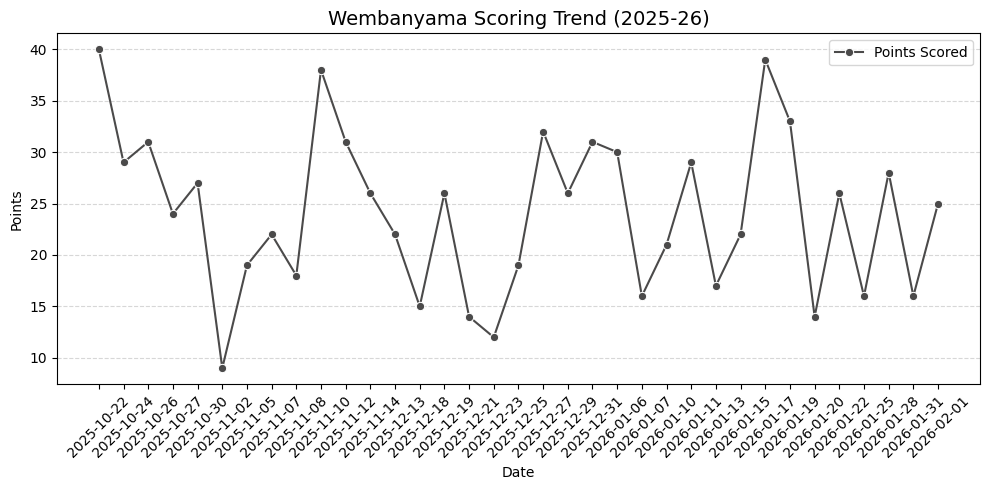

In [4]:
# --- PART 1: DESCRIPTIVE ANALYSIS ---
# Goal: Analyze trends and detect elite performances.

# 1. Load Data
df = pd.read_csv('wemby_career_enriched.csv')

# Focus on Current Season (2025-26) for trends
df_current = df[df['Season'] == 2026].copy()

# 2. Advanced Stats Detection
# Double-Double: >=10 in two stats
df_current['Double_Double'] = (
    ((df_current['Points'] >= 10) & (df_current['Rebounds'] >= 10)) |
    ((df_current['Points'] >= 10) & (df_current['Assists'] >= 10)) |
    ((df_current['Points'] >= 10) & (df_current['Blocks'] >= 10)) |
    ((df_current['Rebounds'] >= 10) & (df_current['Blocks'] >= 10))
).astype(int)

# 5x5: >=5 in all 5 major stats (Rare!)
df_current['5x5'] = (
    (df_current['Points'] >= 5) & 
    (df_current['Rebounds'] >= 5) & 
    (df_current['Assists'] >= 5) & 
    (df_current['Blocks'] >= 5) &
    (df_current['Steals'] >= 5) 
).astype(int)

print("--- 2025/26 Season Summary ---")
print(f"Games Played: {len(df_current)}")
print(f"Double-Doubles: {df_current['Double_Double'].sum()}")
print(f"5x5 Performances: {df_current['5x5'].sum()}")

# 3. Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_current, x='Date', y='Points', marker='o', color='#4B4A4A', label='Points Scored')
plt.title('Wembanyama Scoring Trend (2025-26)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
# --- PART 2: MACHINE LEARNING PREDICTOR ---
# Goal: Build a Betting Advisor for Points, Rebounds, Blocks.

# 1. Feature Engineering
# Encode Opponent (Text -> Number)
le = LabelEncoder()
df['Opponent_Code'] = le.fit_transform(df['Opponent'])

# Calculate Rolling Form (Average of last 3 games)
cols = ['Points', 'Rebounds', 'Assists', 'Blocks', 'Steals']
for col in cols:
    df[f'Forme_{col}'] = df[col].rolling(window=3, closed='left').mean()

df_ml = df.dropna().copy() # Remove early games with no history

# 2. Train Random Forest Models
features = ['Opponent_Code', 'Is_Home', 'Rest_Days', 'Forme_Points', 'Forme_Rebounds', 'Forme_Blocks']
targets = ['Points', 'Rebounds', 'Assists', 'Blocks', 'Steals']
models = {}
margins = {}

for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(df_ml[features], df_ml[target])
    models[target] = model
    
    # Check Accuracy (Mean Absolute Error)
    preds = model.predict(df_ml[features])
    margins[target] = np.mean(np.abs(preds - df_ml[target]))

# 3. The Advisor Function
def wemby_advisor(opponent, is_home=True):
    if opponent not in le.classes_:
        return f"Error: Opponent '{opponent}' not found."
    
    # Context: Latest form + Opponent + Location
    last_game = df_ml.iloc[-1]
    input_data = pd.DataFrame({
        'Opponent_Code': [le.transform([opponent])[0]],
        'Is_Home': [1 if is_home else 0],
        'Rest_Days': [2], # Standard Rest
        'Forme_Points': [last_game['Forme_Points']],
        'Forme_Rebounds': [last_game['Forme_Rebounds']],
        'Forme_Blocks': [last_game['Forme_Blocks']]
    })
    
    loc_str = "Home" if is_home else "Away"
    print(f"\nWEMBY ADVISOR vs {opponent} ({loc_str})")
    print("="*60)
    print(f"{'STAT':<10} | {'SAFE BET (Low Risk)':<25} | {'VALUE BET (Target)':<25}")
    print("-" * 60)
    
    for target in targets:
        pred = models[target].predict(input_data)[0]
        margin = margins[target]
        safe_line = int(pred - margin)
        value_line = int(pred)
        print(f"{target:<10} | {f'{safe_line}+':<25} | {f'Over {value_line}.5':<25}")
    print("="*60)

# --- TEST AREA ---
wemby_advisor('LAL', is_home=True)
wemby_advisor('OKC', is_home=False)


WEMBY ADVISOR vs LAL (Home)
STAT       | SAFE BET (Low Risk)       | VALUE BET (Target)       
------------------------------------------------------------
Points     | 22+                       | Over 25.5                
Rebounds   | 13+                       | Over 14.5                
Assists    | 2+                        | Over 3.5                 
Blocks     | 3+                        | Over 3.5                 
Steals     | 0+                        | Over 1.5                 

WEMBY ADVISOR vs OKC (Away)
STAT       | SAFE BET (Low Risk)       | VALUE BET (Target)       
------------------------------------------------------------
Points     | 19+                       | Over 21.5                
Rebounds   | 10+                       | Over 11.5                
Assists    | 2+                        | Over 2.5                 
Blocks     | 3+                        | Over 3.5                 
Steals     | 0+                        | Over 1.5                 


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- PART 3: INTERACTIVE DASHBOARD ---
# Goal: Create a user-friendly GUI for real-time predictions.

# 1. Create Widgets
# Dropdown for Opponents (Sorted alphabetically)
# Note: 'le' comes from the LabelEncoder defined in the previous cell
opponent_dropdown = widgets.Dropdown(
    options=sorted(le.classes_),
    description='Opponent:',
    style={'description_width': 'initial'}
)

# Radio Buttons for Location
location_radio = widgets.RadioButtons(
    options=[('Home', True), ('Away', False)],
    description='Location:',
    style={'description_width': 'initial'}
)

# The "Predict" Button
predict_button = widgets.Button(
    description='Generate Prediction',
    button_style='success', # Green color
    layout=widgets.Layout(width='50%', height='40px')
)

# Output Area (Where results will appear)
output_area = widgets.Output()

# 2. Define Interaction Logic
def on_button_click(b):
    with output_area:
        clear_output() # Clear previous result
        # Get values from widgets
        selected_opponent = opponent_dropdown.value
        is_home = location_radio.value
        
        # Call the advisor function defined in Cell 3
        wemby_advisor(selected_opponent, is_home)

# Link button to function
predict_button.on_click(on_button_click)

# 3. Display the GUI
print("\n--- WEMBY PREDICTOR DASHBOARD ---")
display(opponent_dropdown, location_radio, predict_button, output_area)


--- WEMBY PREDICTOR DASHBOARD ---


Dropdown(description='Opponent:', options=('ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW…

RadioButtons(description='Location:', options=(('Home', True), ('Away', False)), style=DescriptionStyle(descri…

Button(button_style='success', description='Generate Prediction', layout=Layout(height='40px', width='50%'), s…

Output()